# [Hw01] Classification of the Iris data using the Adaline
Jeong Ji Hoon 2016010980

## 패키지 import & 상수 설정 & 데이터 다운로드

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#%matplotlib inline

#Constants for Data Import
NUM_FEATURE = 4 # Number of Features in each sample
NUM_SAMPLE_PER_CLASS = 50
NUM_CLASS = 3
NUM_TEST_SAMPLE_PER_CLASS = 10

#Dataset Download
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)
dataset = df.values

#Iris name to integer codes
iris_names = np.unique(dataset[:,NUM_FEATURE])
for i,name in enumerate(iris_names):
    dataset[np.where(dataset[:,NUM_FEATURE] == name),NUM_FEATURE] = i

X = dataset[:,:NUM_FEATURE].astype(float)
# Using Only Two Features (Sepal length & Petal Length)
X = X[:,[0,2]]
y = dataset[:,NUM_FEATURE].astype(int)

print('[System] 데이터 불러오기 완료')

[System] 데이터 불러오기 완료


## Class 및 함수 정의
### 1. AdalineClassifier
- 책에 있는 AdalineSGD Class를 응용
- batchsize 값을 통해 전체 training set을 여러번에 나눠서 weight 값 변경에 적용
- 150 샘플중 30개를 test 용으로 사용하므로, 
	- batchsize = 120 인 경우 Batch
	- 1 < batchsize < 120 인 경우 mini batch
	- batchsize = 1 인 경우 stochastic
- 1번 training sample 전체를 train 시키는 것을 하나의 epoch으로 간주
- eta_schedule option으로 매 weight update 마다 eta 값이 감소하게 할 수 있음(learning rate scheduling)

### 2. Multi_AdalineClassifier
- 3 Class classification을 가능하도록 하는 class
- AdalineClassifier를 3개 만들어서 각각 fitting
- input으로 받는 y 값은 각 sample당 3개의 값을 가짐.
	- ex) class 0에 속하는 sample => y = [1, -1, -1]
	- ex) class 2에 속하는 sample => y = [-1, -1, 1]

### 3. plot_decision_regions
- 책에 있는 함수를 응용
- parameter로 axis를 받아서 subplot을 그리기 용이하게 해둠.
- xlabel, ylabel을 추가.


In [12]:
class AdalineClassifier(object):
    """ADAptive LInear NEuron classifier"""

    def __init__(self, eta=0.01, n_iter=10, random_state=None, eta_schedule = False):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.random_state = random_state
        self.eta_schedule = eta_schedule
        self.trial = 0

    def fit(self, X_train, y_train, batchsize):
        """Fit training data.""" # 이후 test 값들은 cost function 만들때만 사용할꺼임.
        self._initialize_weights(X_train.shape[1]) # feature number
        self.cost_train = []
        for i in range(self.n_iter):
            cost = []
            if X_train.shape[0] % batchsize == 0: #training set 크기가 batchsize로 딱 나눠지는 경우
                batch_n_iter = int(X_train.shape[0] / batchsize) # batch를 돌려아 하는 횟수.
                # 딱 나눠지는 경우에는 배치 사이즈 그대로 train을 시킴.
                for b in range(batch_n_iter):
                    cost.append(self._update_weights(X_train[batchsize * b : batchsize *(b + 1),:],
                                                     y_train[batchsize * b : batchsize *(b + 1)]))
            else: #training set 크기가 batchsize로 딱 나눠지지 않는 경우
                batch_n_iter = int(np.floor(X_train.shape[0] / batchsize))
                # 배치 사이즈 그대로 train을 시키고,
                for b in range(batch_n_iter):
                    cost.append(self._update_weights(X_train[batchsize * b : batchsize * (b + 1),:],
                                                     y_train[batchsize * b : batchsize * (b + 1)]))
                # 나머지를 전부 넣어줌.
                cost.append(self._update_weights(X_train[batchsize*batch_n_iter :, :],
                                                 y_train[batchsize*batch_n_iter :]))
            avg_cost = np.mean(cost)
            self.cost_train.append(avg_cost)
        return self

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        if self.eta_schedule: # for learning rate scheduling
            eta_ = 1.0 / (1.0 / self.eta + self.trial)
            self.trial += 1
        else:
            eta_ = self.eta
        self.w_[1:] += eta_ * xi.T.dot(error)
        self.w_[0] += eta_ * error.sum()
        cost = 0.5 * (error ** 2).sum()
        return cost

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X


class Multi_AdalineClassifier(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=None, eta_schedule = False):  # make 3 adaline classifiers.
        self.clf = [AdalineClassifier(eta=eta, n_iter=n_iter, random_state=random_state, eta_schedule = eta_schedule),
                    AdalineClassifier(eta=eta, n_iter=n_iter, random_state=random_state, eta_schedule = eta_schedule),
                    AdalineClassifier(eta=eta, n_iter=n_iter, random_state=random_state, eta_schedule = eta_schedule)]

    def fit(self, X_train, targetY_train, batchsize):  # train each classifiers with appropriate samples
        self.numClass = targetY_train.shape[1]
        for c in range(self.numClass):
            self.clf[c].fit(X_train, targetY_train[:, c], batchsize)

    def predict(self, X):
        self.output = np.zeros([X.shape[0], self.numClass])
        self.result = np.zeros([X.shape[0]])
        for c in range(self.numClass):
            self.output[:, c] = self.clf[c].net_input(X)
        for s in range(X.shape[0]):
            self.result[s] = np.where(self.output[s, :] == np.amax(self.output[s, :]))[0]
        return self.result


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02, ax = None):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Petal Length')
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')
    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100,
                    label='test set')

print('[System] Class Creation success')

[System] Class Creation success


## 3.1 Learning Rate

In [6]:
eta_set = [0.1, 0.01, 0.001, 0.0001]
n_iter = 20

training set / test set 나누기

In [7]:
# Divide train(0.8)/test(0.2) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y)

targetY_train = -1 * np.ones([y_train.size, np.unique(y_train).__len__()])
for s, c in enumerate(y_train):
    targetY_train[s, c] = 1

targetY_test = -1 * np.ones([y_test.size, np.unique(y_test).__len__()])
for s, c in enumerate(y_test):
    targetY_test[s, c] = 1

연산 시작

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig1, ax = plt.subplots(nrows=4, ncols=3,figsize=(15,15))
mclf = [None] * 4
for ie, e in enumerate(eta_set):
    mclf[ie] = Multi_AdalineClassifier(eta = e, n_iter = n_iter, eta_schedule = True)
    mclf[ie].fit(X_train,targetY_train,120)
    for c in range(NUM_CLASS):
        ax[ie,c].plot(range(n_iter),np.log(mclf[ie].clf[c].cost_train))
        ax[ie,c].set_xlabel('Epochs')
        ax[ie,c].set_ylabel('log(Sum-squared-error)')
        ax[ie,c].set_title('Adaline(Class' + str(c) + 'vs rest) - eta=' + str(e))
    # Performance
    y_pred = mclf[ie].predict(X_test)
    print('Eta = ' + str(e))
    print('     Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('     Misclassified samples: %d' % (y_test != y_pred).sum())

plt.show()

Eta = 0.1
     Accuracy: 0.33
     Misclassified samples: 20
Eta = 0.01
     Accuracy: 0.33
     Misclassified samples: 20
Eta = 0.001
     Accuracy: 0.33
     Misclassified samples: 20
Eta = 0.0001
     Accuracy: 0.67
     Misclassified samples: 10


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

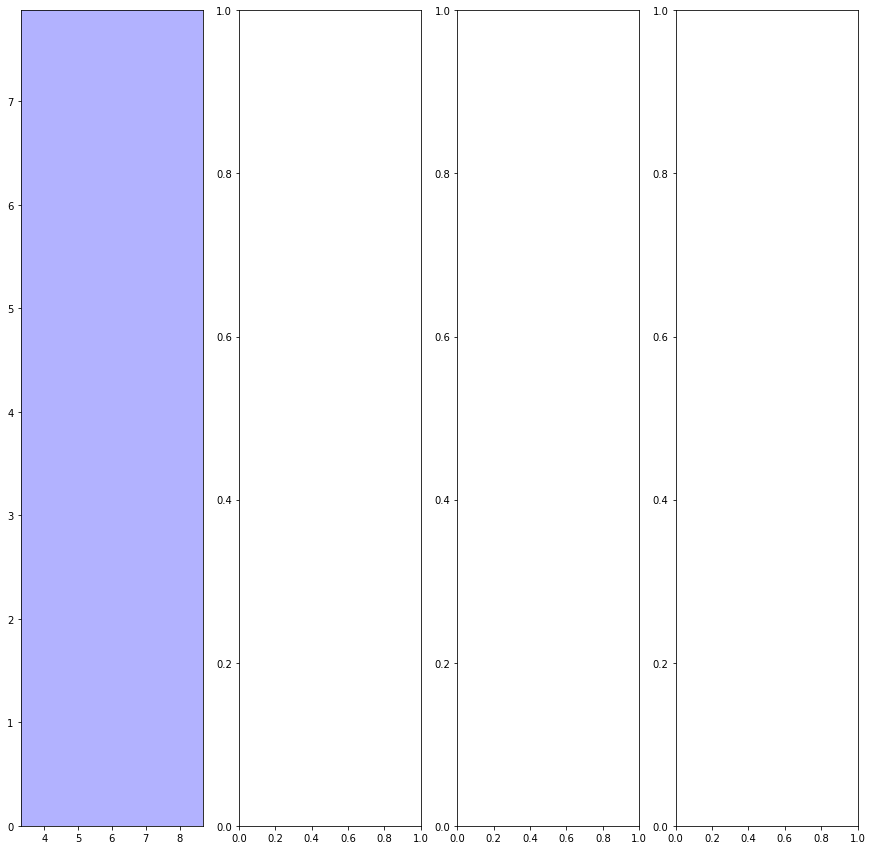

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig2, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for ie, _ in enumerate(eta_set):
    plot_decision_regions(X_train, y_train,mclf[ie],ax = ax[ie])
plt.show()

- 분석
	- 총 3개의 class에 대해 각각 classifier가 존재. 
		- (각 열이 왼쪽부터 Class 0 vs rest, 1 vs rest, 2 vs rest)
	- eta 값이 0.1, 0.01, 0.001 인 경우 epoch이 증가할 수록 오히려 모든 classifier의 cost function이 증가.
	- 또한 Accuracy도 chance level = 0.33 임을 알 수 있음.
	- eta = 0.0001 인 경우는 나름 classify를 함.
	- **eta 값이 너무 커지면 global minimum으로 수렴하지 못하는 것으로 보임.**
	- **단 class 1(파랑)의 경우 현재 평면에서 파랑 vs rest로 나눌 수 있는 hyperplane이 존재하지 않음.**
	- 이러한 이유가 classification accuracy가 67% 이상으로 올라가지 않는 것을 설명해줌.
	- PCA transform을 통해 새로운 평면에 plotting 하거나 feature의 수를 늘리거나, 현재 feature를 다른 차원으로 transform 해주면 성공적으로 분류가 가능할 것으로 추측됨.

## 3.2 Feature Scaling

In [17]:
X[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()
# Divide train(0.8)/test(0.2) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=y)

targetY_train = -1 * np.ones([y_train.size, np.unique(y_train).__len__()])
for s, c in enumerate(y_train):
    targetY_train[s, c] = 1

targetY_test = -1 * np.ones([y_test.size, np.unique(y_test).__len__()])
for s, c in enumerate(y_test):
    targetY_test[s, c] = 1

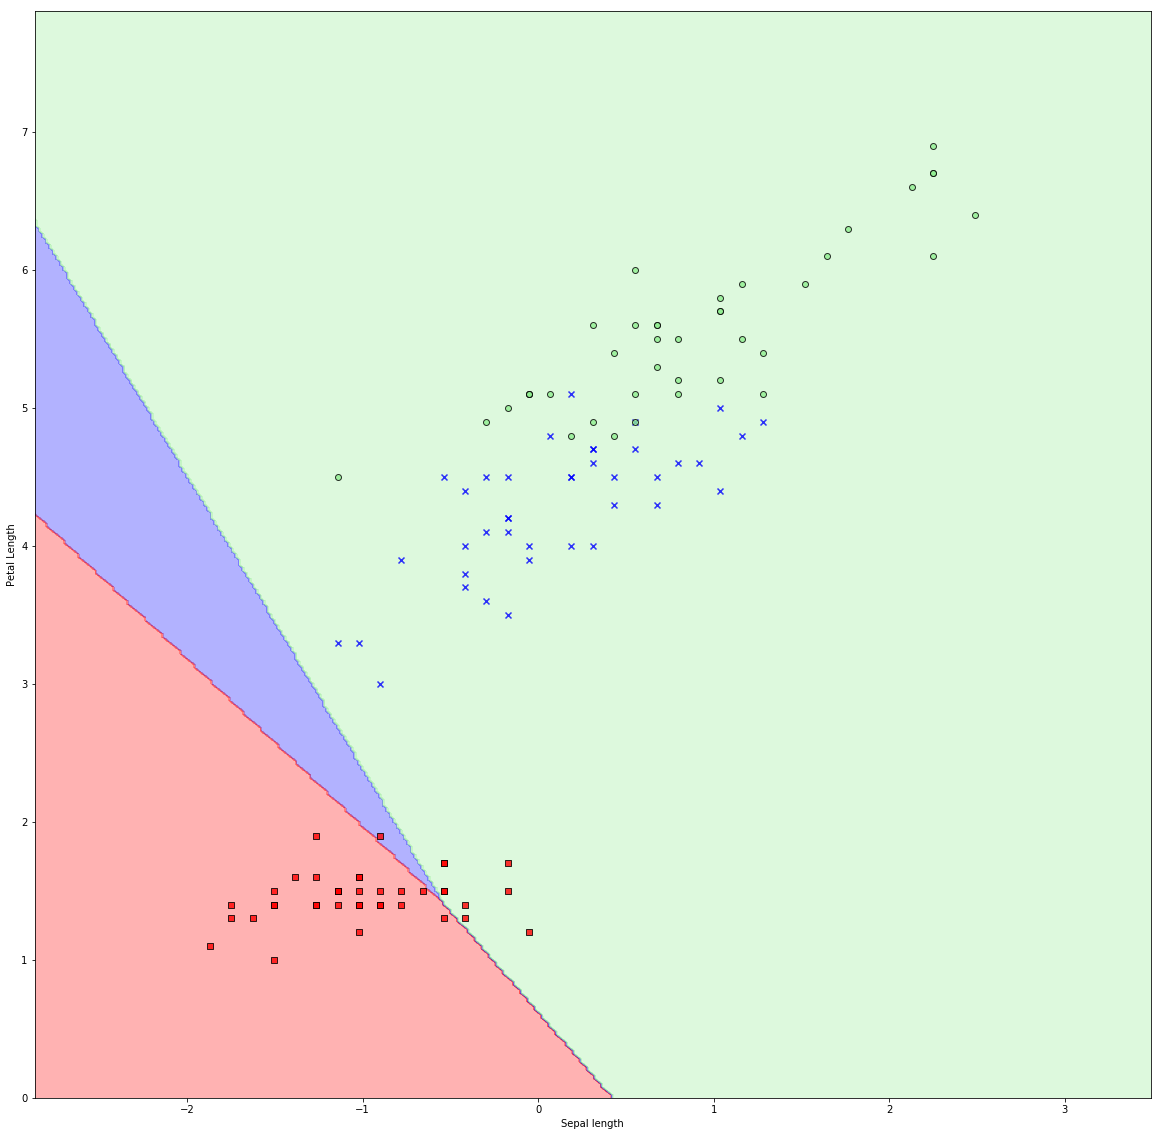

In [22]:
fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
mclf = Multi_AdalineClassifier(eta = 0.0001, n_iter = 20, eta_schedule = True)
mclf.fit(X_train,targetY_train,120)
for c in range(NUM_CLASS):
    ax[c].plot(range(n_iter),np.log(mclf.clf[c].cost_train))
    ax[c].set_xlabel('Epochs')
    ax[c].set_ylabel('log(Sum-squared-error)')
    ax[c].set_title('Adaline(Class' + str(c) + 'vs rest)')
# Performance
y_pred = mclf.predict(X_test)
print('     Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('     Misclassified samples: %d' % (y_test != y_pred).sum())

plt.show()


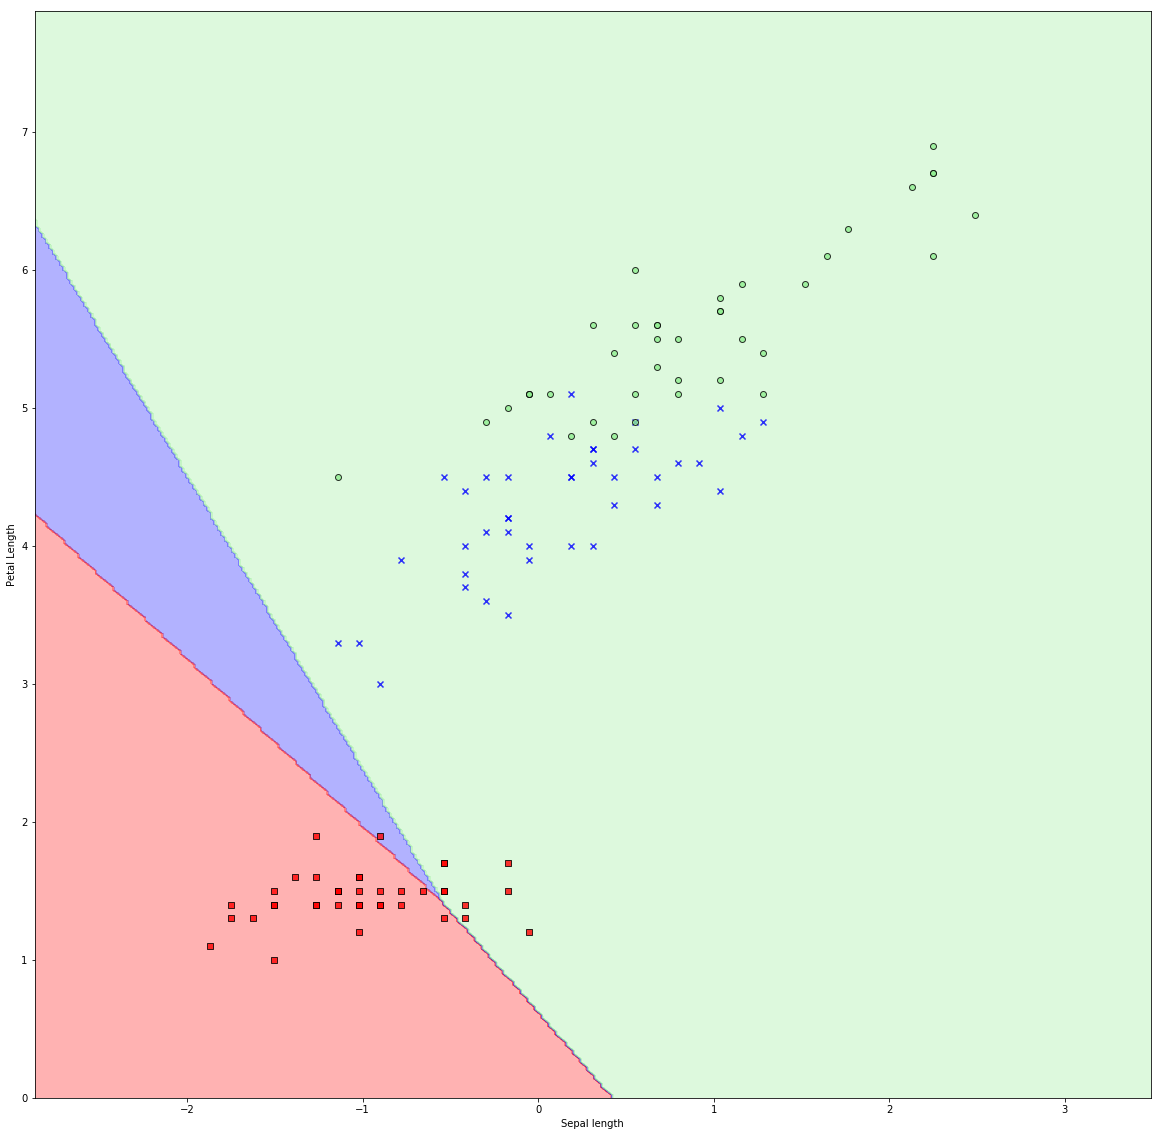

In [26]:
fig2, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
plot_decision_regions(X_train, y_train,mclf,ax = ax)
plt.show()


- 분석
	- 이전에서는 Class 1이 다른 class들과 나뉘는 것이 완벽히 불가능 했는데, feature scaling으로 세 class에 속하는 sample들이 사방으로 퍼지면서 Class1이 Class0와 Class2와 조금이나마 분리가 되었음. 
	- 분리가 충분하지 않아서 역시 Performance는 떨어지지만, decision boundary가 보이기 시작하는 것을 관찰할 수 있음.

## 3.3 Batch Size

In [13]:
n_iter = 20
batch_set = [1,2,4,8,16,32,120]

In [15]:
fig1, ax = plt.subplots(nrows=7, ncols=3, figsize=(20,20))
mclf = [None] * 7
for ib, b in enumerate(batch_set):
    mclf[ib] = Multi_AdalineClassifier(eta = 0.0001, n_iter = n_iter, eta_schedule = True)
    mclf[ib].fit(X_train,targetY_train,b)
    for c in range(NUM_CLASS):
        ax[ib,c].plot(range(n_iter),np.log(mclf[ib].clf[c].cost_train))
        ax[ib,c].set_xlabel('Epochs')
        ax[ib,c].set_ylabel('log(Sum-squared-error)')
        ax[ib,c].set_title('Adaline(Class' + str(c) + 'vs rest) - batchsize=' + str(b))
    # Performance
    y_pred = mclf[ib].predict(X_test)
    print('Batchsize = ' + str(b))
    print('     Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    print('     Misclassified samples: %d' % (y_test != y_pred).sum())

plt.show()

Batchsize = 1
     Accuracy: 0.67
     Misclassified samples: 10
Batchsize = 2
     Accuracy: 0.67
     Misclassified samples: 10
Batchsize = 4
     Accuracy: 0.67
     Misclassified samples: 10
Batchsize = 8
     Accuracy: 0.67
     Misclassified samples: 10
Batchsize = 16
     Accuracy: 0.67
     Misclassified samples: 10
Batchsize = 32
     Accuracy: 0.67
     Misclassified samples: 10
Batchsize = 120
     Accuracy: 0.67
     Misclassified samples: 10


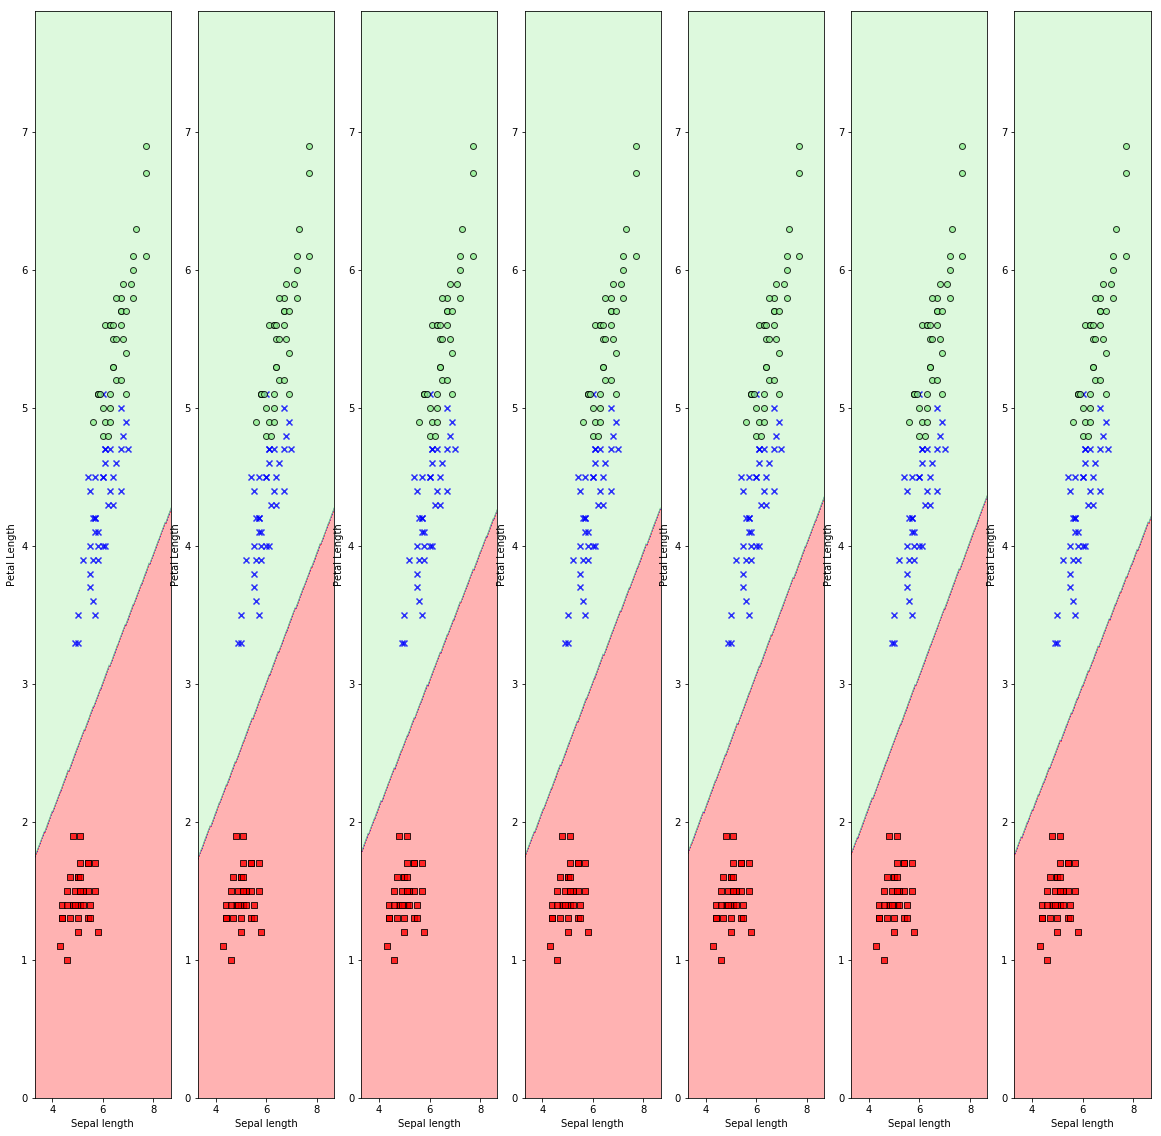

In [16]:
fig2, ax = plt.subplots(nrows=1, ncols=7, figsize=(20,20))
for ib, _ in enumerate(batch_set):
    plot_decision_regions(X_train, y_train,mclf[ib],ax = ax[ib])
plt.show()

- 분석
	- batch size가 작아지면 하나의 epoch에서 여러번 weight 수정을 거치기에 처음부터 cost 가 작게 잡힘.
	- 이 역시 Class 1을 분류하는 classifier가 제대로 작동을 안해서 batchsize에 의한 차이가 극명하게 드러나지는 않았음.